# CartaGen4Py Test

In this section, we'll try to demonstrate how to use the cartagen4py python library.

## Generalization algorithms

Different algorithms are available, keep in mind that you need to understand what you are doing in order to correctly generalize your data. The order in which you must apply those algorithms really depends on your approach to generalization as well as the specificities of your datasets.

### Line simplification

#### Visvalingam-Whyatt simplification

Visvalingam-Whyatt simplification (1993) uses triangular areas to eliminate nodes inside the polyline.

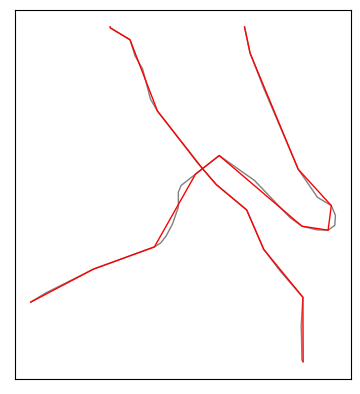

In [17]:
import matplotlib
import cartagen4py as c4
import geopandas as gp

# Loading the lines as a GeoDataFrame
lines = gp.read_file('data/test_lines.geojson')

# Creating an empty list to store simplified lines
slines = []

# Looping through the geometry of each lines
for line in lines.geometry:
    # Simplifying lines using the Visvalingam-Whyatt algorithm with an area of 200
    simplified = c4.visvalingam_whyatt(line, 200)
    # Adding the simplified line to list
    slines.append(simplified)

# Creating a new GeoSeries from the list of simplified lines
generalized = gp.GeoSeries(slines)

# Plotting the original and the simplified lines
original = lines.plot(edgecolor='gray',linewidth=1)
generalized.plot(ax=original, edgecolor='red', linewidth=1)
original.axes.get_xaxis().set_visible(False)
original.axes.get_yaxis().set_visible(False)

#### Raposo simplification

Raposo simplification (2010) uses an hexagonal tessellation with a size based on the final scale of the map to eliminate nodes inside the polyline.

[(402346.20645881805, 5799807.72747814), (402345.1571867916, 5799821.533825041), (402336.1523390402, 5799877.183896951), (402311.06649179, 5799908.5419523055), (402295.8379854494, 5799943.778750412), (402262.53563569835, 5799973.565549681), (402256.39524170087, 5799980.674809409)]
[(402256.39524170087, 5799980.674809409), (402256.39524170087, 5799980.674809409), (402251.65527955355, 5799986.162669313), (402212.9884544266, 5800037.524736377), (402187.7326815594, 5800092.112327265), (402173.5944526549, 5800107.72747814)]
[(402102.4630139197, 5799861.199802448), (402109.08746565826, 5799865.253025161), (402159.1153868571, 5799891.003908191), (402221.51831040863, 5799919.278403784), (402234.8126405966, 5799946.316319228), (402244.65550452983, 5799970.436527623), (402256.39524170087, 5799980.674809409)]
[(402256.39524170087, 5799980.674809409), (402256.39524170087, 5799980.674809409), (402264.2455139623, 5799986.837216082), (402287.09383944765, 5799981.191910681), (402351.6897569677, 579992

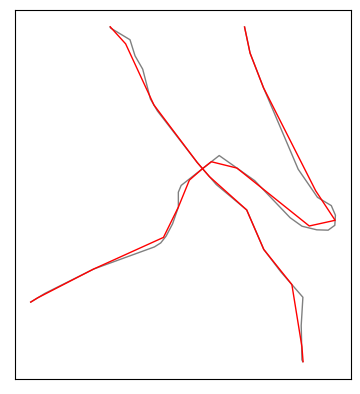

In [16]:
import matplotlib
import cartagen4py as c4
import geopandas as gp

# Loading the lines as a GeoDataFrame
lines = gp.read_file('data/test_lines.geojson')

# Creating an empty list to store simplified lines
slines = []

# Looping through the geometry of each lines
for line in lines.geometry:
    # Simplifying lines using the Visvalingam-Whyatt algorithm with an area of 200
    simplified = c4.raposo_simplification(line, 25000, 100000, centroid=True, tobler=False)
    # Adding the simplified line to list
    slines.append(simplified)

# Creating a new GeoSeries from the list of simplified lines
generalized = gp.GeoSeries(slines)

# Plotting the original and the simplified lines
original = lines.plot(edgecolor='gray',linewidth=1)
generalized.plot(ax=original, edgecolor='red', linewidth=1)
original.axes.get_xaxis().set_visible(False)
original.axes.get_yaxis().set_visible(False)